# Forecasting the number of antidiabetic drug prescriptions in Australia
The goal of this project is to accurately predict the number of antidiabetic medications prescribed in Australia from 1991-2008. By solving this problem, pharmaceutical companies can better estimate output and avoid overproduction or shortages. The data used will come from the Australian Health Insurance Commission's records.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read the csv file "AusAntidiabeticDrug.csv" from the current working directory
df = pd.read_csv('AusAntidiabeticDrug.csv')

# display the first 10 rows of the dataframe
df.head(10)




,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [3]:
# display the last 10 rows of the dataframe
df.tail(10)


,ds,y
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [4]:
# get the number of rows and columns of the dataframe
df.shape


(204, 2)

## Visualization 

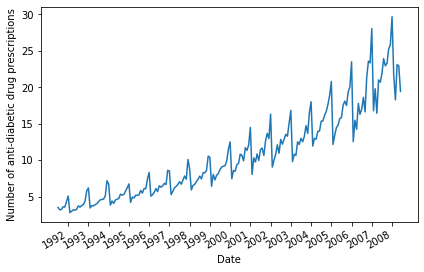

In [5]:
# initialize the figure and axis objects
fig, ax = plt.subplots()

# plot the y column from the dataframe on the axis
ax.plot(df.y)

# set the x-axis label
ax.set_xlabel('Date')

# set the y-axis label
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

# set the x-axis tick locations and labels
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

# format the x-axis tick labels
fig.autofmt_xdate()

# adjust the subplot layout
plt.tight_layout()


In the figure, we see a clear trend in the time series, as the number of prescriptions
increases over time. Furthermore, we observe strong seasonality, as each year seems
to start at a low value and end at a high value.

The goal is to forecast 12 months of antidiabetic drug prescriptions using the last 36 months of data as a test set. To do so, we will visualize the time series and use time series decomposition to extract trend and seasonal components. We then need to apply transformations in order to make it stationary, set values for d and D, m, and find the optimal (p,d,q)(P,D,Q)m parameters. After validating our model with the residual analysis we can perform rolling forecasts for 12 months on the test set. Finally, we need to compare our model's performance with an appropriate baseline and error metric in order to decide whether or not it should be used.

## Exploration 

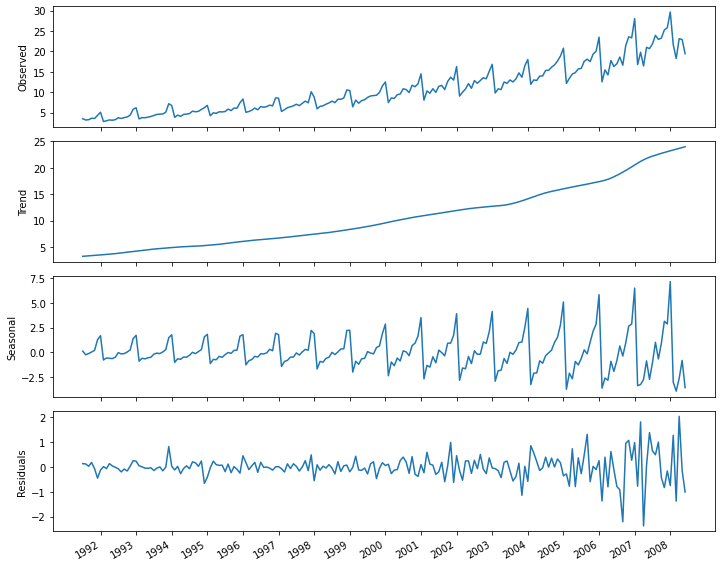

In [6]:
# perform the STL decomposition on the y column of the dataframe
decomposition = STL(df.y, period=12).fit()

# initialize the figure and axis objects (4 rows, 1 column, shared x-axis)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

# plot the observed values on ax1
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

# plot the trend on ax2
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

# plot the seasonal component on ax3
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

# plot the residuals on ax4
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# set the x-axis tick locations and labels
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

# format the x-axis tick labels
fig.autofmt_xdate()

# adjust the subplot layout
plt.tight_layout()


Time series decomposition on the antidiabetic drug prescriptions dataset. The first plot shows the observed data. The second plot shows the trend component, which tells us that the number of antidiabetic drug prescriptions is increasing over time. The third plot shows the seasonal component, where we can see a repeating pattern over time, indicating the presence of seasonality. The last plot shows the residuals, which are variations that are not explained by the trend of the seasonal component.

From the result shown, it is clear that a SARIMA(p,d,q) (P,D,Q)m model would be the optimal solution for forecasting this time series. We have a trend as well as clear seasonality.

## Modeling 
To start our modeling,first determine
whether the series is stationary using the augmented Dickey-Fuller (ADF) test.

In [7]:
# perform the Augmented Dickey-Fuller test on the y column of the dataframe
ad_fuller_result = adfuller(df.y)

# extract and print the ADF statistic and p-value from the results
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: 3.1451856893067363
p-value: 1.0


This returns a p-value of 1.0, meaning that we cannot reject the null hypothesis, and
we conclude that the series is not stationary. Thus, we must apply transformations to
make it stationary.

In [8]:
# calculate the first difference of the y column of the dataframe
y_diff = np.diff(df.y, n=1)

# perform the Augmented Dickey-Fuller test on the first difference of y
ad_fuller_result = adfuller(y_diff)

# extract and print the ADF statistic and p-value from the results
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -2.4951721474497512
p-value: 0.11665341686468494


This returns a p-value of 0.12. Again, the p-value is greater than 0.05, meaning that the
series is not stationary. Let’s try applying a seasonal difference, since we noticed a
strong seasonal pattern in the data. 

Recall that we have monthly data, meaning that
m = 12. Thus, a seasonal difference subtracts values that are 12 timesteps apart.

In [9]:
# calculate the first difference of the y column of the dataframe
y_diff = np.diff(df.y, n=1)

# calculate the seasonal difference of the first difference of y
y_diff_seasonal_diff = np.diff(y_diff, n=12)

# perform the Augmented Dickey-Fuller test on the seasonal difference of the first difference of y
ad_fuller_result = adfuller(y_diff_seasonal_diff)

# extract and print the ADF statistic and p-value from the results
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -19.848440097482005
p-value: 0.0


The returned p-value is 0.0. Thus, we can reject the null hypothesis and conclude that
our time series is stationary.

### Train/test split 

We have established that our model will be a SARIMA(p,1,q)(P,1,Q)12 model. Now we
need to find the optimal values of p, q, P, and Q. This is the model selection step where
we choose the parameters that minimize the Akaike information criterion (AIC).
To do so, we’ll first split the data into train and test sets. The test set will consist of the last 36 months of data.

In [10]:
# split the y column of the dataframe into a training set and a test set
train = df.y[:168]
test = df.y[168:]

# print the length of the test set
print(len(test))


36


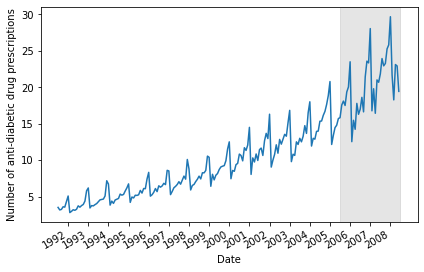

In [11]:
# create a plot of the y column of the dataframe
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

# add a shaded area to the plot to indicate the test set
ax.axvspan(168, 204, color='#808080', alpha=0.2)

# set the x-axis tick marks and labels
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

# format the x-axis tick labels
fig.autofmt_xdate()

# adjust the layout of the plot
plt.tight_layout()


With our split done, we can now use the optimize_SARIMAX function to find the values
of p, q, P, and Q that minimize the AIC. Note that we can use optimize_SARIMAX
here because SARIMA is a special case of the more general SARIMAX model.

### SARIMA(p,1,q)(P,1,Q)<sub>12<sub> 

In [12]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    """
    Optimize SARIMAX models for a given time series data.

    Parameters:
        endog (Union[pd.Series, list]): Endogenous data.
        exog (Union[pd.Series, list]): Exogenous data.
        order_list (list): List of order parameters (p, q, P, Q).
        d (int): Non-seasonal difference order.
        D (int): Seasonal difference order.
        s (int): Seasonality.

    Returns:
        pd.DataFrame: DataFrame containing the best SARIMAX models, sorted by AIC.
    """
    # Store the results of the SARIMAX models
    results = []
    
    # Loop over each order in order_list
    for order in tqdm_notebook(order_list):
        try: 
            # Fit the SARIMAX model with the given order and seasonal parameters
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            # Skip the iteration if the model fails to fit
            continue
            
        # Store the AIC of the model
        aic = model.aic
        results.append([order, model.aic])
        
    # Create a DataFrame from the results
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # Sort the DataFrame by AIC in ascending order (lower AIC is better)
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


With the function defined, we can now decide on the range of values to try for p, q, P,
and Q. Then we’ll generate a list of unique combinations of parameters.

In [27]:
# Define the range of possible values for each order parameter
ps = range(0, 5) # p - Autoregression order
qs = range(0, 5) # q - Moving average order
Ps = range(0, 5) # P - Seasonal autoregression order
Qs = range(0, 5) # Q - Seasonal moving average order

# Generate all possible combinations of order parameters
order_list = list(product(ps, qs, Ps, Qs))

# Set the seasonal difference order (d)
d = 1
# Set the seasonal difference order (D)
D = 1
# Set the seasonality (s)
s = 12



In [14]:
# Call the optimize_SARIMAX function with the given arguments
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)

# Display the result of the optimization
print(SARIMA_result_df)


  0%|          | 0/625 [00:00<?, ?it/s]

        (p,q,P,Q)         AIC
0    (3, 1, 1, 3)  270.951096
1    (2, 4, 1, 3)  271.218671
2    (3, 3, 1, 3)  271.428202
3    (4, 1, 1, 3)  272.145292
4    (0, 4, 1, 3)  272.152380
..            ...         ...
620  (0, 0, 2, 4)  353.229070
621  (0, 0, 0, 1)  354.751719
622  (0, 0, 4, 4)  356.412600
623  (0, 0, 1, 0)  357.173706
624  (0, 0, 0, 0)  357.531871

[625 rows x 2 columns]


Once the function is finished, the result shows that the minimum AIC is achieved with
p = 2, q = 3, P = 1, and Q = 3. Therefore, the optimal model is a SARIMA(2,1,3)(1,1,3)12
model.

In [15]:
# Create a SARIMA model object with order (2, 1, 3) for the non-seasonal component
# and seasonal order (1, 1, 3, 12) for the seasonal component
# with simple_differencing set to False
model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)

# Fit the SARIMA model to the training data, setting disp=False to suppress output
fit = model.fit(disp=False)

# Print a summary of the SARIMA model fit
print(fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(2, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -128.117
Date:                            Tue, 07 Feb 2023   AIC                            276.234
Time:                                    04:19:10   BIC                            306.668
Sample:                                         0   HQIC                           288.596
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1310      0.055    -20.745      0.000      -1.238      -1.024
ar.L2         -0.9658      0.064   

Now that we have the optimal model, we must analyze its residuals to determine
whether the model can be used or not. This will depend on the residuals, which should
behave like white noise. If that is the case, the model can be used for forecasting.
We can fit the model and use the plot_diagnostics method to qualitatively analyze
its residuals.

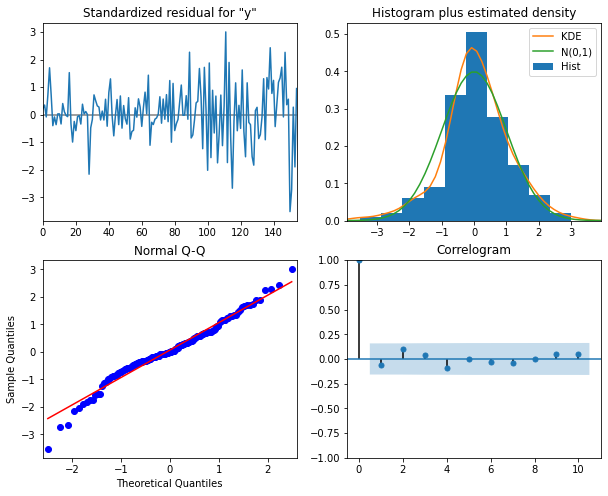

In [16]:
# Plot the diagnostics of the SARIMA model fit
fit.plot_diagnostics(figsize=(10,8));



Visual diagnostics of the residuals. In the top-left plot, the residuals have no trend over time,
and the variance seems constant. At the top right, the distribution of the residuals is very close to a
normal distribution. This is further supported by the Q-Q plot at the bottom left, which displays a fairly
straight line that sits on y = x. Finally, the correlogram at the bottom right shows no significant
coefficients after lag 0, just like white noise.

The result shows that we can conclude from this qualitative analysis
that the residuals closely resemble white noise.

The next step is to perform the Ljung-Box test, which determines whether the
residuals are independent and uncorrelated. The null hypothesis of the Ljung-Box
test states that the residuals are uncorrelated, just like white noise. Thus, we want
the test to return p-values larger than 0.05. In that case, we cannot reject the null
hypothesis and conclude that our residuals are independent, and therefore behave
like white noise.

In [28]:
# Obtain the residuals from the SARIMA model fit
residuals = fit.resid

# Calculate the Ljung-Box test statistics and p-values for the residuals
# for lags 1 to 10 (inclusive)
ljung_box, p_values = acorr_ljungbox(residuals, lags=range(1, 11))

# Print the p-values
print(p_values)


[0.23220664 0.42980045 0.52106849 0.43439226 0.5015316  0.62847942
 0.24140818 0.32385512 0.40063231 0.49401222]


In this case, all the p-values are above 0.05, so we do not reject the null hypothesis, and
we conclude that the residuals are independent and uncorrelated. We can conclude
that the model can used for forecasting.

## Forecasting 

We have a model that can be used for forecasting, so we’ll now perform rolling forecasts
of 12 months over the test set of 36 months. That way we’ll have a better evaluation
of our model’s performance, as testing on fewer data points might lead to skewed
results. We’ll use the naive seasonal forecast as a baseline; it will simply take the last 12
months of data and use them as forecasts for the next 12 months.
We’ll first define the rolling_forecast function to generate the predictions over the
entire test set with a window of 12 months. The function is shown in the following listing.

In [29]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    # Total length of the prediction window
    total_len = train_len + horizon
    
    # Index of the end of the training data
    end_idx = train_len
    
    if method == 'last_season':
        # Initialize a list to store the predictions
        pred_last_season = []
        
        # Loop over the window of the prediction horizon
        for i in range(train_len, total_len, window):
            # Get the last season values
            last_season = df['y'][i-window:i].values
            # Extend the predictions with the last season values
            pred_last_season.extend(last_season)
            
        # Return the predictions
        return pred_last_season
    
    elif method == 'SARIMA':
        # Initialize a list to store the predictions
        pred_SARIMA = []
        
        # Loop over the window of the prediction horizon
        for i in range(train_len, total_len, window):
            # Fit the SARIMA model on the training data
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            # Get the out-of-sample (OOS) predictions
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            # Extend the predictions with the OOS predictions
            pred_SARIMA.extend(oos_pred)
            
        # Return the predictions
        return pred_SARIMA


Next, we’ll create a DataFrame to hold the predictions as well as the actual values. This
is simply a copy of the test set.

In [19]:
# Slice the dataframe to start from the 168th row
pred_df = df[168:]

# Print the sliced dataframe
print(pred_df)


             ds          y
168  2005-07-01  15.829550
169  2005-08-01  17.554701
170  2005-09-01  18.100864
171  2005-10-01  17.496668
172  2005-11-01  19.347265
173  2005-12-01  20.031291
174  2006-01-01  23.486694
175  2006-02-01  12.536987
176  2006-03-01  15.467018
177  2006-04-01  14.233539
178  2006-05-01  17.783058
179  2006-06-01  16.291602
180  2006-07-01  16.980282
181  2006-08-01  18.612189
182  2006-09-01  16.623343
183  2006-10-01  21.430241
184  2006-11-01  23.575517
185  2006-12-01  23.334206
186  2007-01-01  28.038383
187  2007-02-01  16.763869
188  2007-03-01  19.792754
189  2007-04-01  16.427305
190  2007-05-01  21.000742
191  2007-06-01  20.681002
192  2007-07-01  21.834890
193  2007-08-01  23.930204
194  2007-09-01  22.930357
195  2007-10-01  23.263340
196  2007-11-01  25.250030
197  2007-12-01  25.806090
198  2008-01-01  29.665356
199  2008-02-01  21.654285
200  2008-03-01  18.264945
201  2008-04-01  23.107677
202  2008-05-01  22.912510
203  2008-06-01  19.431740


Now we can define the parameters to be used for the rolling_forecast function.
The dataset contains 204 rows, and the test set contains 36 data points, which means
the length of the training set is 204 – 36 = 168. The horizon is 36, since our test set
contains 36 months of data. Finally, the window is 12 months, as we are forecasting 12
months at a time.
With those values set, we can record the predictions coming from our baseline,
which is a naive seasonal forecast. It simply takes the last 12 months of observed data
and uses them as forecasts for the next 12 months.

In [20]:
# Define the length of the training data
TRAIN_LEN = 168

# Define the length of the prediction horizon
HORIZON = 36

# Define the size of the rolling window
WINDOW = 12

# Add a new column to the sliced dataframe with the predictions from the "last_season" method
pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

# Print the updated sliced dataframe
print(pred_df)


             ds          y  last_season
168  2005-07-01  15.829550    15.339097
169  2005-08-01  17.554701    15.370764
170  2005-09-01  18.100864    16.142005
171  2005-10-01  17.496668    16.685754
172  2005-11-01  19.347265    17.636728
173  2005-12-01  20.031291    18.869325
174  2006-01-01  23.486694    20.778723
175  2006-02-01  12.536987    12.154552
176  2006-03-01  15.467018    13.402392
177  2006-04-01  14.233539    14.459239
178  2006-05-01  17.783058    14.795102
179  2006-06-01  16.291602    15.705248
180  2006-07-01  16.980282    15.829550
181  2006-08-01  18.612189    17.554701
182  2006-09-01  16.623343    18.100864
183  2006-10-01  21.430241    17.496668
184  2006-11-01  23.575517    19.347265
185  2006-12-01  23.334206    20.031291
186  2007-01-01  28.038383    23.486694
187  2007-02-01  16.763869    12.536987
188  2007-03-01  19.792754    15.467018
189  2007-04-01  16.427305    14.233539
190  2007-05-01  21.000742    17.783058
191  2007-06-01  20.681002    16.291602


Next, we’ll compute the forecasts from the SARIMA model.

In [21]:
# Add a new column to the sliced dataframe with the predictions from the "SARIMA" method
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

# Print the updated sliced dataframe
print(pred_df)


             ds          y  last_season     SARIMA
168  2005-07-01  15.829550    15.339097  16.748738
169  2005-08-01  17.554701    15.370764  16.684522
170  2005-09-01  18.100864    16.142005  17.189678
171  2005-10-01  17.496668    16.685754  18.088524
172  2005-11-01  19.347265    17.636728  18.657014
173  2005-12-01  20.031291    18.869325  19.951105
174  2006-01-01  23.486694    20.778723  22.073787
175  2006-02-01  12.536987    12.154552  13.744533
176  2006-03-01  15.467018    13.402392  15.087160
177  2006-04-01  14.233539    14.459239  15.657503
178  2006-05-01  17.783058    14.795102  16.674500
179  2006-06-01  16.291602    15.705248  16.891570
180  2006-07-01  16.980282    15.829550  17.746725
181  2006-08-01  18.612189    17.554701  18.333670
182  2006-09-01  16.623343    18.100864  18.815253
183  2006-10-01  21.430241    17.496668  19.450138
184  2006-11-01  23.575517    19.347265  20.241754
185  2006-12-01  23.334206    20.031291  21.124248
186  2007-01-01  28.038383    2

At this point, pred_df contains the actual values, the forecasts from the naive seasonal
method, and the forecasts from the SARIMA model. We can use this to visualize our forecasts against the actual values. For clarity, we’ll limit the x-axis to zoom in on the
test period. The resulting plot is shown below.

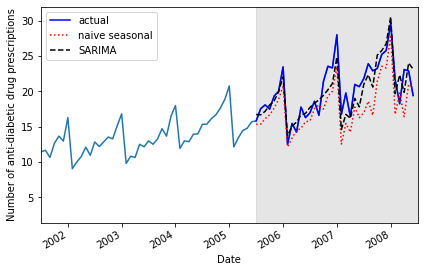

In [30]:
# Initialize a figure and axis for plotting
fig, ax = plt.subplots()

# Plot the actual values of "y" from the original dataframe
ax.plot(df.y)

# Plot the actual values of "y" from the sliced dataframe in blue
ax.plot(pred_df.y, 'b-', label='actual')

# Plot the predictions from the "last_season" method in red with dotted line
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')

# Plot the predictions from the "SARIMA" method in black with a dashed line
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')

# Set the x-axis label as "Date"
ax.set_xlabel('Date')

# Set the y-axis label as "Number of anti-diabetic drug prescriptions"
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

# Shade the area from the 168th row to the 204th row in gray with 20% opacity
ax.axvspan(168, 204, color='#808080', alpha=0.2)

# Add a legend to the top left of the plot
ax.legend(loc=2)

# Set the x-ticks to be spaced every 12 rows, labeled with years from 1992 to 2009
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

# Set the x-axis limits from the 120th row to the 204th row
plt.xlim(120, 204)

# Automatically format the x-axis tick labels to be angled to avoid overlap
fig.autofmt_xdate()

# Adjust the layout to ensure everything fits nicely within the plot
plt.tight_layout()


From the resulting plot we can see that the predictions from the SARIMA model (the dashed
line) follow the actual values more closely than the naive seasonal forecasts (the dotted
line). We can therefore intuitively expect the SARIMA model to have performed
better than the baseline method.

## Evaluate 

To evaluate the performance quantitatively, we’ll use the mean absolute percentage
error (MAPE). The MAPE is easy to interpret, as it returns a percentage error.

In [31]:
def mape(y_true, y_pred):
    """
    Calculates the mean absolute percentage error (MAPE) between two arrays.
    
    Parameters:
    y_true (array-like): The true values
    y_pred (array-like): The predicted values
    
    Returns:
    float: MAPE between y_true and y_pred
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [32]:
# Calculate MAPE for the naive seasonal method and SARIMA method
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

# Print the MAPE values
print("MAPE for naive seasonal method: {:.2f}%".format(mape_naive_seasonal))
print("MAPE for SARIMA method: {:.2f}%".format(mape_SARIMA))


MAPE for naive seasonal method: 12.69%
MAPE for SARIMA method: 7.90%


This prints out a MAPE of 12.69% for the baseline and 7.90% for the SARIMA model.
We can optionally plot the MAPE of each model in a bar chart for better visualization of the result.

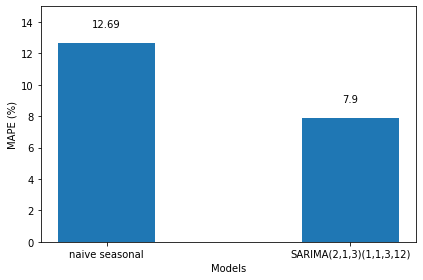

In [33]:
# Create subplots and assign them to fig and ax
fig, ax = plt.subplots()

# Define the x-axis labels
x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']

# Define the y-axis values
y = [mape_naive_seasonal, mape_SARIMA]

# Plot the bar chart with width 0.4
ax.bar(x, y, width=0.4)

# Set the x-axis label
ax.set_xlabel('Models')

# Set the y-axis label
ax.set_ylabel('MAPE (%)')

# Set the y-axis limit to 0 to 15
ax.set_ylim(0, 15)

# Add the value on top of each bar
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

# Adjust the layout
plt.tight_layout()


Since
the MAPE of the SARIMA model is lower than the MAPE of the baseline, we can
conclude that the SARIMA model should be used to forecast the number of antidiabetic